In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

# Define model and create sample trajectory

In [2]:
M  = 2                  # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1./7            
gIh   = 1/14
gIc   = 1/14
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter
fh = 0.1 
gE    = 1/5
gA    = 1/3

hh   = 0.1*np.ones(M)       # fraction which goes from Is to hospital
cc   = 0.05*np.ones(M)      # fraction which goes from  hospital to ICU 
mm   = 0.4*np.ones(M)       # mortality from IC
sa = 0  # change in the population, not taken into account by inference at the moment 

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
Ia0 = np.array([0, 0])  # each age group has asymptomatic infectives
Is0 = np.array([0, 0])   # and also symptomatic infectives
R0  = np.zeros((M))
E0  = np.array([10, 10])
A0  = np.array([10, 10])
Ih0  = np.zeros((M))
Ic0  = np.zeros((M))
Im0  = np.zeros((M))
S0  = Ni - (Ia0+Is0+R0+E0+A0+Ih0+Ic0+Im0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE, 'gA':gA,
              'fsa':fsa, 'fh':fh, 
              'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SEAI5R(parameters, M, Ni)
data = sto_model.simulate(S0, E0, A0, Ia0, Is0, Ih0, Ic0, Im0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('sto_traj.npy', data_array)

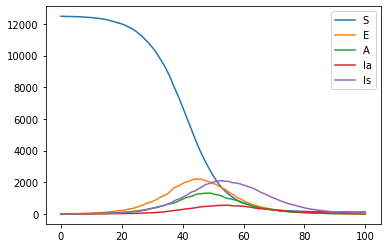

In [3]:
# plot the stochastic solution 
plt.plot(data_array[:, 0], label='S')
plt.plot(data_array[:, M], label='E')
plt.plot(data_array[:, 2*M], label='A')
plt.plot(data_array[:, 3*M], label='Ia')
plt.plot(data_array[:, 4*M], label='Is')

plt.legend()
plt.show()

# Infer parameters based on part of the trajectory

In [4]:
# load the data and rescale to intensive variables 
Tf_inference = 30 # truncate to only getting the first few datapoints 
Nf_inference = Tf_inference+1

x = np.load('sto_traj.npy').astype('float')
x = (x[:,:8*M]/N)[:Nf_inference]
steps = 101 # number internal integration steps taken


# initialise the estimator 
estimator = pyross.inference.SEAI5R(parameters, M, fi, int(N), steps)

## create filter to distinguish between observable classes
fltr=np.repeat(np.array([False, False, False, False, True, True, True, True]), M)
obs=x[:,fltr]
x0 = x[0]

In [5]:
alpha_g = 0.4          ## bad initial guess
beta_g  = 0.03         ## bad initial guess
gIa_g   = 1./7            
gIs_g   = 1./7   
gE_g    = 1/5
gA_g    = 1/3
   

S0_g = S0/N
E0_g = E0/N
A0_g  = A0/N
Ia0_g = Ia0/N

# optimisation parameters 
eps = 1e-4 # step used to calculate hessian in the optimisation algorithm 
ftol = 1e-3 # the relative tol in (-logp)  

# set up bounds for all the classes
bounds_for_E  = [(1/N, 14/N)]*M 
bounds_for_A  = [(1/N, 14/N)]*M 
bounds_for_Ia = [(0.1/N, 100/N)]*M
bounds_for_Is = [(1/N, 14/N)]*M 
bounds_for_Ih = [(1/N, 14/N)]*M 
bounds_for_Ic = [(1/N, 14/N)]*M 
bounds_for_Im = [(1/N, 14/N)]*M 
bounds_for_S = [(fi[i]-100/N-Is0[i]/N, fi[i]-0.1/N) for i in range(M)]

# set up bounds for the rest of the params 
alpha_b = (0.1,0.5)
beta_b  = (eps, 0.04)
gIa_b   = (eps, 0.2)
gIs_b   = (eps, 0.2)
gE_b    = (0.15, 0.25)
gA_b    = (0.3, 0.4)

# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 
bounds = np.array([alpha_b, beta_b, gIa_b, gIs_b, gE_b, gA_b, *bounds_for_S, *bounds_for_E, *bounds_for_A, *bounds_for_Ia, *bounds_for_Is, *bounds_for_Ih, *bounds_for_Ic, *bounds_for_Im])

# make an initial guess and do inference 
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, gE_g, gA_g, *S0_g, *E0_g, *A0_g, *Ia0_g, *Is0, *Ih0, *Ic0, *Im0])
params = estimator.latent_inference(guess, obs, fltr, Tf_inference, Nf_inference, 
                                    contactMatrix, bounds, verbose=True, niter=4, ftol=ftol, eps=eps)
# the L-BFGS-B method prints to the terminal rather than here 

parameters: [0.43240106 0.02031208 0.16137204 0.16137204 0.18379947 0.35493404]
parameters: [0.419574   0.0241595  0.15404351 0.15403546 0.19020056 0.34638449]
parameters: [0.42248781 0.02325941 0.15570954 0.15569518 0.18874384 0.34832847]
parameters: [0.42673283 0.02189054 0.15813885 0.15810172 0.18662148 0.35116348]
basinhopping step 0: f -2339.63
parameters: [0.4414529  0.0115994  0.13076642 0.19826328 0.19882818 0.31067737]
parameters: [0.40927032 0.01840893 0.09270293 0.19729909 0.22567675 0.31654261]
parameters: [0.41793518 0.01672211 0.10295546 0.19755405 0.21844553 0.31496082]
parameters: [0.42309191 0.01571327 0.10905561 0.19770557 0.21414298 0.31401942]
parameters: [0.42968833 0.01441367 0.11685702 0.19789995 0.20864058 0.31281562]
parameters: [0.4297674  0.01447329 0.11694919 0.19789761 0.20857548 0.31279893]
parameters: [0.42723355 0.01500007 0.11395193 0.19782122 0.21068945 0.31326051]
basinhopping step 1: f -2339.63 trial_f -2289.66 accepted 0  lowest_f -2339.63
parameter

In [ ]:
np.save('latent_SEAI5R_params.npy', params)

In [ ]:
params = np.load('latent_SEIR_params.npy')
print('best estimates for params: ', params[:6])
print('best estimates for initial conditions: ', params[6:])

In [6]:
hess_params, hess_init = estimator.hessian_latent(params, obs[1:], fltr, Tf_inference, Nf_inference, contactMatrix)

LinAlgError: Singular matrix

In [ ]:
cov_params = np.linalg.inv(hess_params)
cov_init = np.linalg.inv(hess_init)

# Compare forecast based on inferred parameters to full trajectory

In [10]:
parameters = {'alpha': params[0], 'beta': params[1], 'gIa': params[2], 'gIs': params[3],
              'gE':params[4],'gA':params[5],
            'S0':params[6: 5+M],
            'E0':params[6+M:6+2*M],
            'A0':params[6+2*M:6+3*M],
            'Ia0':params[6+3*M:6+4*M],
            'Is0':params[6+4*M:6+5*M],
            'Ih0':params[6+5*M:6+6*M],
            'Ic0':params[6+6*M:6+7*M],
            'Im0':params[6+7*M:6+8*M],
                 'fsa':fsa, 'fh':fh, 
              'gIh':gIh,'gIc':gIc,
              'sa':sa, 
              'hh':hh, 'cc':cc, 'mm':mm,
             'cov_init':cov_init, 'cov_params':cov_params}

# Initialise pyross forecast module
model_forecast = pyross.forecast.SEAI5R(parameters, M, Ni)

In [15]:
# Number of simulations over which we average
Ns = 500 

Tf_forecast = Tf #- Tf_inference
Nf_forecast = Tf_forecast+1


result_forecast = model_forecast.simulate(contactMatrix, Tf_forecast, Nf_forecast,
                                      verbose=True,
                                     Ns=Ns) 

trajectories_forecast = result_forecast['X']
t_forecast = result_forecast['t']# + Tf_inference

Finished. Time needed for evaluation: 00:00:04


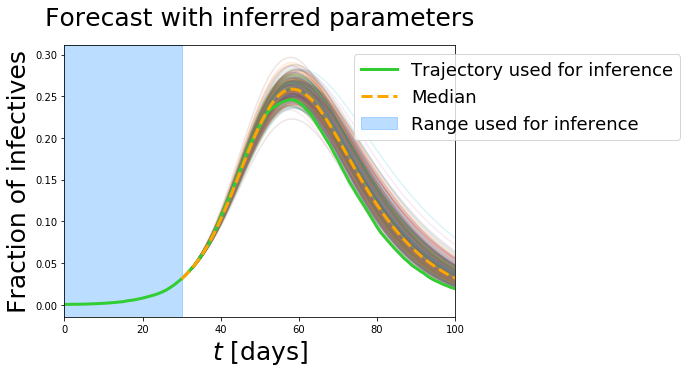

In [19]:
# Plot sum of A, Ia, Is populations

fontsize=25
#

ylabel=r'Fraction of infectives'
#

# Plot total number of symptomatic infectives
cur_trajectories_forecast = np.sum( trajectories_forecast[:,2*M:5*M,:] , axis = 1)
cur_mean_forecast = np.mean( cur_trajectories_forecast, axis=0)
percentile = 10
percentiles_lower = np.percentile(cur_trajectories_forecast,percentile,axis=0)
percentiles_upper = np.percentile(cur_trajectories_forecast,100-percentile,axis=0)
percentiles_median = np.percentile(cur_trajectories_forecast,50,axis=0)


cur_trajectory_underlying = np.sum( data_array[:,2*M:5*M] ,axis=1 )

#
# Plot trajectories
#
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.axvspan(0, Tf_inference, 
           label='Range used for inference',
           alpha=0.3, color='dodgerblue')
ax.set_title(r'Forecast with inferred parameters',
             y=1.05,
            fontsize=fontsize)
for i,e in enumerate(cur_trajectories_forecast):
    ax.plot(t_forecast,e/N,
            alpha=0.15,
           )
ax.plot(cur_trajectory_underlying/N,
        lw=3,
        color='limegreen',
       label='Trajectory used for inference')

ax.plot(t_forecast,percentiles_median/N,
                alpha=1,ls='--',
        color='orange',label='Median',
       lw=3)
''' # remove comments to plot percentiles
ax.plot(t_forecast,percentiles_lower/N,
                alpha=1,
        lw=2,
        label='Percentiles',
        ls='dotted',
        color='red',
       )
ax.plot(t_forecast,percentiles_upper/N,
                alpha=1,
        lw=2,
        color='red',
        ls='dotted',
       )
''';

ax.set_xlim(0,np.max(t_forecast))
ax.set_ylabel(ylabel,fontsize=fontsize)
ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
ax.legend(loc='upper right',bbox_to_anchor=(1.6,1),
          fontsize=18)
plt.show(fig)
#fig.savefig('inference_forecast.png',dpi=100,bbox_inches='tight')
plt.close(fig)